## Aim

The goal of this notebook is to do some basic statistical analysis on the entire set of CoinJoin candidate transactions (see below for a definition), and at the same time investigate to what extent transactions generated by the three main CoinJoin coordinators, Wasabi, Samourai and JoinMarket can be identified.

## Data

Transactions from all blocks up to 622'500 were scanned for CoinJoin candidates. A CJ candidate tx is defined as having at least two equally valued non-zero outputs. There are no restrictions on the rest of the outputs. 


## Limitations
Naturally, this will include many false positives. We attempt to filter out some of them below. Also, CoinJoins based on non-equally valued outputs are not captured, such as pay-to-endpoint.

In [1]:
%pylab inline
import pickle
import seaborn as sns
import pandas as pd
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


In [3]:
(all_cjs, all_txids, processed, failures) = pickle.load(open('cjs.p','rb'))
cjs = pd.DataFrame(all_cjs, columns=["height", "n_vin", "n_vout", "cj_value", "cj_part", "max_out", "min_out", "op_r", "wasabi"])
cjs.height = cjs.height.astype(np.int32)
cjs.n_vin = cjs.n_vin.astype(np.int32)
cjs.n_vout = cjs.n_vout.astype(np.int32)
cjs["log_cj_value"] = log10(cjs.cj_value)
cjs.cj_part = cjs.cj_part.astype(np.int32)
cjs.op_r = cjs.op_r.astype(np.int32)
cjs.wasabi = cjs.wasabi.astype(np.int32)
cjs.dtypes

height           int32
n_vin            int32
n_vout           int32
cj_value        object
cj_part          int32
max_out         object
min_out         object
op_r             int32
wasabi           int32
log_cj_value    object
dtype: object

As a preliminary sanity check, make sure that a couple of CJ transactions from the three providers are in there.

In [7]:
txids = set(all_txids)

known_wasabi = "19646d922fca705efee55f61bf4b2041e0077498f694d8e177e992729bda960a"
print(known_wasabi in txids)
known_samourai = "4c2bf8d0379bcfc301603717dc61dbe348b2516bddb908df01ae512bb6d40f16"
print(known_samourai in txids)
known_join_market = [
    "ca48b14f0a836b91d8719c51e50b313b425356a87111c4ed2cd6d81f0dbe60de",
    "615e269c65d2e78928938b7675095ea0437b5b976217d4210a980d37b56b35b4",
    "51a2f747b6efe36762c05771d9168bc9d2aea8e90474b2b53594f34aa054ba18",
    "55eac9d4a4159d4ba355122c6c18f85293c19ae358306a3773ec3a5d053e2f1b",
    "402d3e1df685d1fdf82f36b220079c1bf44db227df2d676625ebcbee3f6cb22a",
    "722bb2662cb2ef9b4a2693e52ba82c44cea1042349f1aa6e71e28a3947aa4144",
    "3b97544488cac0271a80b20822597342648d19ed02ac25041bd8d35e624d8e6b"
]
print(all([kjm in txids for kjm in known_join_market]))

True
True
True


In [19]:
def show_stats(data):
    print("{} CoinJoin candidates".format(data.shape[0]))
    figure(figsize=(15,5))
    subplot(1,2,1)
    hist(data.height, bins=100)
    xlabel("Height")
    ylabel("Bin count")
    subplot(1,2,2)
    hist(np.array(data.log_cj_value, dtype=np.float32),bins=50)
    xlabel("Log10(CJ value)")
    ylabel("Bin count")

def common_values(data):
    cj_values = Counter(data.cj_value)
    common = cj_values.most_common()
    print("10 most common output values")
    for c in common[:10]:
        print(c)


### Some basic statistics on the entire dataset

7989272 CoinJoin candidates
10 most common output values
(Decimal('0.00001000'), 498440)
(Decimal('0.00000546'), 348317)
(Decimal('0.01000000'), 316796)
(Decimal('0.00003000'), 313958)
(Decimal('0.00010000'), 262012)
(Decimal('0.00000600'), 198625)
(Decimal('0.00100000'), 155331)
(Decimal('0.00020000'), 148033)
(Decimal('0.10000000'), 145725)
(Decimal('0.00001250'), 128438)


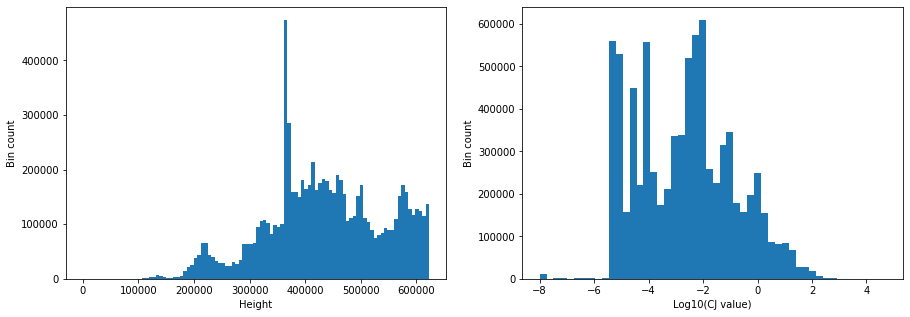

In [20]:
show_stats(cjs)
common_values(cjs)

Round output numbers are vastly over-represented, consistent with CoinJoin usage (although see below for Wasabi).

Now we start to try to clean up the dataset by applying some heuristic filtering characteristics that we think a CoinJoin should fulfill.

## Removing TXs with an OP_RETURN output

6980579 CoinJoin candidates
10 most common output values
(Decimal('0.00001000'), 470844)
(Decimal('0.01000000'), 316744)
(Decimal('0.00010000'), 258695)
(Decimal('0.00100000'), 155222)
(Decimal('0.00020000'), 146397)
(Decimal('0.10000000'), 145628)
(Decimal('0.00001250'), 128434)
(Decimal('1.00000000'), 109174)
(Decimal('0.00500000'), 94070)
(Decimal('0.00007800'), 85679)


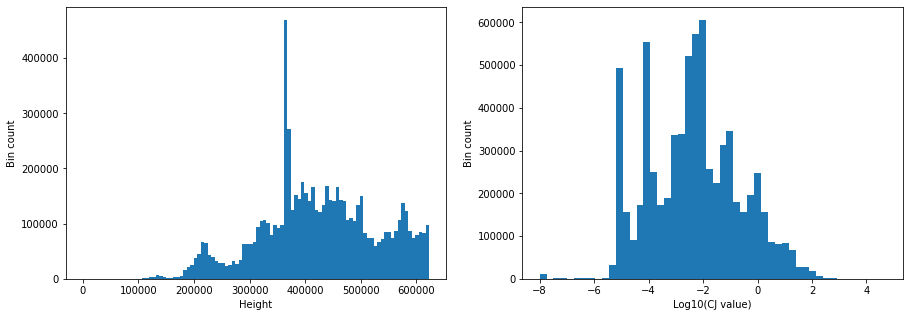

In [22]:
cjs_mod = cjs[cjs.op_r==0]
show_stats(cjs_mod)
common_values(cjs_mod)

## Removing TXs with fewer inputs than outputs

6502249 CoinJoin candidates
10 most common output values
(Decimal('0.00001000'), 470726)
(Decimal('0.01000000'), 272492)
(Decimal('0.00010000'), 251658)
(Decimal('0.00100000'), 147742)
(Decimal('0.00020000'), 144594)
(Decimal('0.00001250'), 128433)
(Decimal('0.10000000'), 125031)
(Decimal('1.00000000'), 97615)
(Decimal('0.00500000'), 87239)
(Decimal('0.00007800'), 82059)


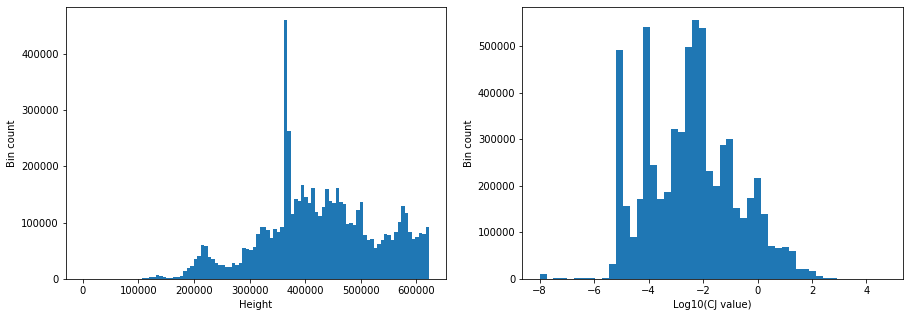

In [23]:
cjs_mod = cjs_mod[cjs_mod.n_vout >= cjs_mod.n_vin]
show_stats(cjs_mod)
common_values(cjs_mod)

## Removing TXs with equal-valued outputs less than 0.001 BTC

This finally gets rid of the weird peak in the height histogram.

4145519 CoinJoin candidates
10 most common output values
(Decimal('0.01000000'), 272492)
(Decimal('0.10000000'), 125031)
(Decimal('1.00000000'), 97615)
(Decimal('0.00500000'), 87239)
(Decimal('0.00200000'), 66637)
(Decimal('0.05000000'), 59024)
(Decimal('0.02000000'), 47839)
(Decimal('0.50000000'), 33700)
(Decimal('10.00000000'), 31059)
(Decimal('0.00490000'), 30206)


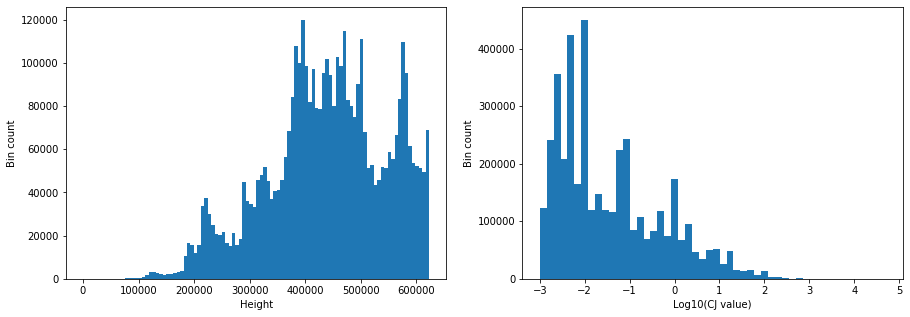

In [25]:
cjs_mod = cjs_mod[cjs_mod.cj_value >= 1e-3]
show_stats(cjs_mod)
common_values(cjs_mod)

# CoinJoin coordinators

## Wasabi CJs

For an extended period, Wasabi used a constant coordinator fee address (bc1qs604c7jv6amk4cxqlnvuxv26hv3e48cds4m0ew) for their CoinJoin transactions. We analyze those clearly identified CJs in this section.

In [32]:
print("{} Wasabi CJ transactions".format(sum(cjs.wasabi)))
wasabi = cjs[cjs.wasabi==1]

5337 Wasabi CJ transactions


In [33]:
print("Ignore {} putative test transactions where the output is smaller than 0.001 BTC".format(wasabi[cjs.cj_value < 0.001].shape[0]))
wasabi = wasabi[wasabi.cj_value >= 0.001]
print("Ignore {} putative test transactions where the output is larger than 0.35 BTC".format(wasabi[cjs.cj_value > 0.35].shape[0]))
wasabi = wasabi[wasabi.cj_value <= 0.35]

/home/spd/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Ignore 3 putative test transactions where the output is smaller than 0.001 BTC
Ignore 1 putative test transactions where the output is larger than 0.35 BTC


/home/spd/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


5333 CoinJoin candidates
10 most common output values
(Decimal('0.10000964'), 3)
(Decimal('0.10000851'), 3)
(Decimal('0.10000957'), 3)
(Decimal('0.10000962'), 3)
(Decimal('0.09981744'), 3)
(Decimal('0.09981823'), 3)
(Decimal('0.09981803'), 3)
(Decimal('0.09981811'), 3)
(Decimal('0.09980548'), 3)
(Decimal('0.09980522'), 3)


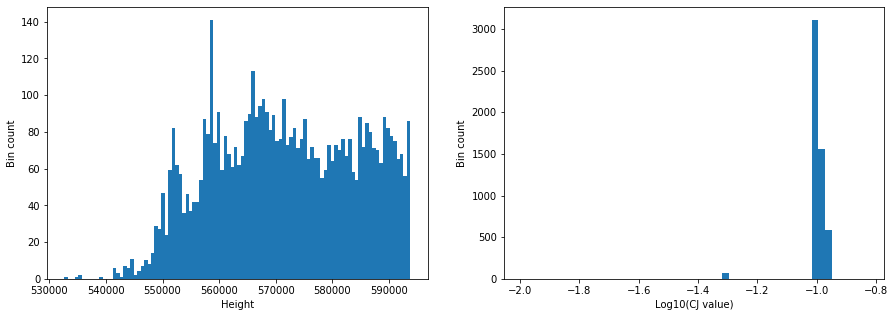

In [34]:
show_stats(wasabi)
common_values(wasabi)

Wasabi transactions distinguish themselves by a large number of participants (typically more than 50 nowadays), and non-round output values, always around 0.1 BTC.

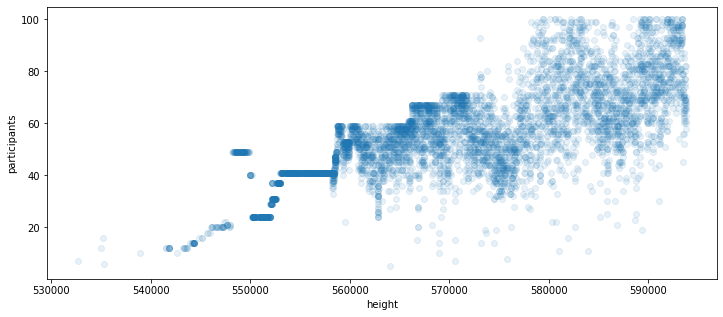

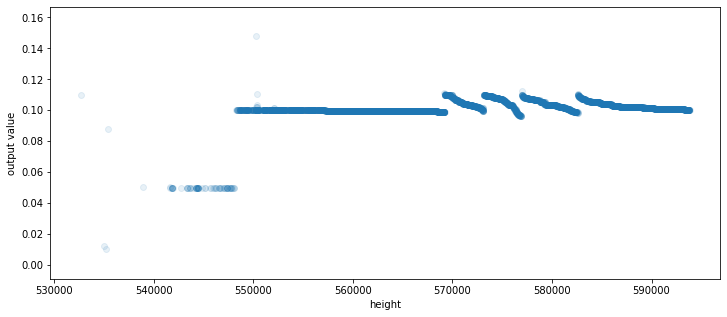

In [40]:
figure(figsize=(12,5))
scatter(wasabi.height, wasabi.cj_part, alpha=0.1)
xlabel("height")
ylabel("participants")
figure(figsize=(12,5))
scatter(wasabi.height, wasabi.cj_value, alpha=0.1)
xlabel("height")
_=ylabel("output value")

## Samourai CoinJoin

Samourai CJs have a very peculiar structure: No change-outputs. Let's look at all txs that fulfill this.

In [45]:
samourai_candidates = cjs_mod[cjs_mod.n_vout == cjs_mod.cj_part]

131729 CoinJoin candidates
10 most common output values
(Decimal('0.01000000'), 18079)
(Decimal('0.05000000'), 8643)
(Decimal('0.50000000'), 3960)
(Decimal('1.00000000'), 3758)
(Decimal('0.00240000'), 2900)
(Decimal('5.00000000'), 2826)
(Decimal('0.00490000'), 2545)
(Decimal('0.00313671'), 1742)
(Decimal('10.00000000'), 1540)
(Decimal('0.04990000'), 1508)


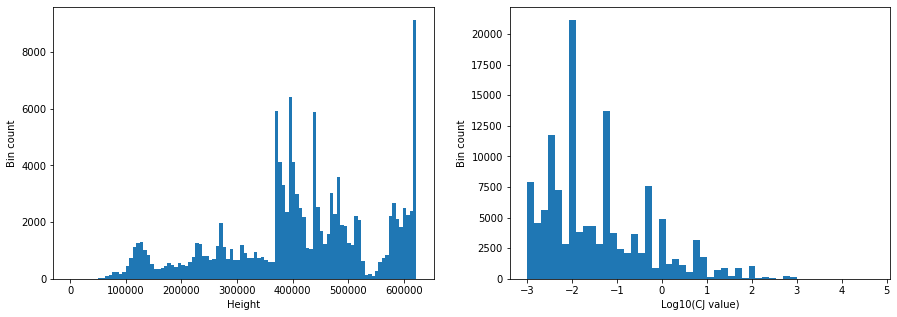

In [46]:
show_stats(samourai_candidates)
common_values(samourai_candidates)

The three most common amounts above, 0.01, 0.05 and 0.5 BTC correspond exactly to the three pool sizes Samourai offers.

We pick those and restrict the height to >550'000 (didn't exist before)

17981 CoinJoin candidates


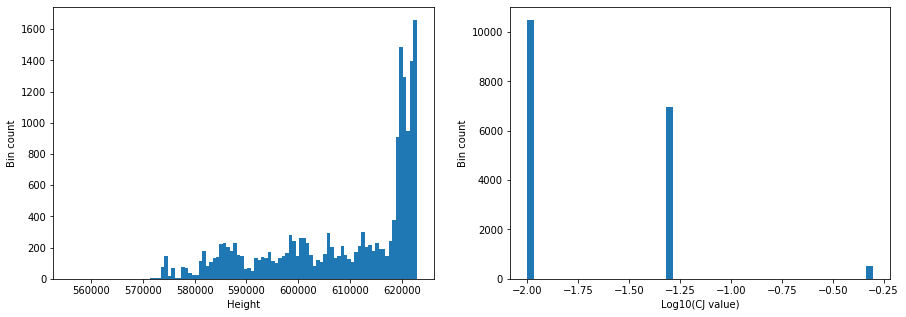

In [61]:
from decimal import Decimal
samourai = samourai_candidates[(samourai_candidates.cj_value==Decimal('0.01')) | (samourai_candidates.cj_value==Decimal('0.05')) | (samourai_candidates.cj_value==Decimal('0.5'))]
samourai = samourai[samourai.height > 550000]
show_stats(samourai)

Comparison between Wasabi and Samourai usage.

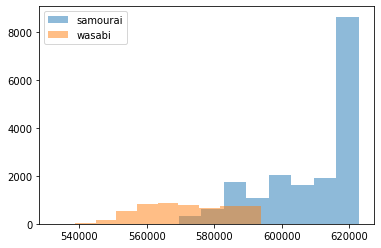

In [66]:
hist(samourai.height, alpha=0.5)
hist(wasabi.height, alpha=0.5)
legend(['samourai', 'wasabi'])

## JoinMarket CoinJoin

ToDo. Much harder since there is no obvious marker.